In [1]:
pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [3]:
class Generator(nn.Module):
    def __init__(self, nz=100, num_classes=10, embed_size=100):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, embed_size)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + embed_size, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([noise, label_embedding], dim=1).view(-1, noise.size(1) + label_embedding.size(1), 1, 1)
        return self.main(x)


In [4]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, 28*28)
        self.main = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels).view(-1, 1, 28, 28)
        x = torch.cat([img, label_embedding], dim=1)
        return self.main(x).view(-1)


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform
    ),
    batch_size=128, shuffle=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
num_epochs = 20
nz = 100
netG = Generator(nz=nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(dataloader):
        real_images, labels = real_images.to(device), labels.to(device)
        batch_size = real_images.size(0)

        real = torch.ones(batch_size).to(device)
        fake = torch.zeros(batch_size).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, nz).to(device)
        fake_images = netG(z, labels)

        netD.zero_grad()
        real_output = netD(real_images, labels)
        d_loss_real = criterion(real_output, real)

        fake_output = netD(fake_images.detach(), labels)
        d_loss_fake = criterion(fake_output, fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        z = torch.randn(batch_size, nz).to(device)
        gen_images = netG(z, labels)
        output = netD(gen_images, labels)
        g_loss = criterion(output, real)

        g_loss.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

Epoch [1/20], D Loss: 1.1672875881195068, G Loss: 0.9537572860717773
Epoch [2/20], D Loss: 1.0810935497283936, G Loss: 1.2788455486297607
Epoch [3/20], D Loss: 1.0189862251281738, G Loss: 1.3357768058776855
Epoch [4/20], D Loss: 0.8249855041503906, G Loss: 1.4095805883407593
Epoch [5/20], D Loss: 0.7516676187515259, G Loss: 1.4425773620605469
Epoch [6/20], D Loss: 0.8079614639282227, G Loss: 1.86129891872406
Epoch [7/20], D Loss: 0.7442914247512817, G Loss: 2.4762847423553467
Epoch [8/20], D Loss: 0.761359691619873, G Loss: 1.6569585800170898
Epoch [9/20], D Loss: 0.7858825325965881, G Loss: 1.5121759176254272
Epoch [10/20], D Loss: 0.6547123789787292, G Loss: 1.7591170072555542
Epoch [11/20], D Loss: 0.5840176939964294, G Loss: 2.1751492023468018
Epoch [12/20], D Loss: 0.5960791110992432, G Loss: 2.2737579345703125
Epoch [13/20], D Loss: 0.5922218561172485, G Loss: 2.1225337982177734
Epoch [14/20], D Loss: 0.5716654062271118, G Loss: 2.1638922691345215
Epoch [15/20], D Loss: 0.6865421

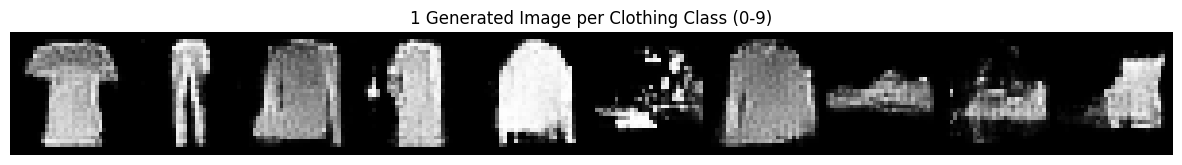

In [10]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Set model to evaluation mode
netG.eval()

# Generate one image for each clothing class (0-9)
z = torch.randn(10, nz).to(device)
labels = torch.arange(10).to(device)

with torch.no_grad():
    generated_images = netG(z, labels)

# Denormalize and visualize
grid = vutils.make_grid(generated_images.cpu(), nrow=10, normalize=True)
plt.figure(figsize=(15, 2))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("1 Generated Image per Clothing Class (0-9)")
plt.show()

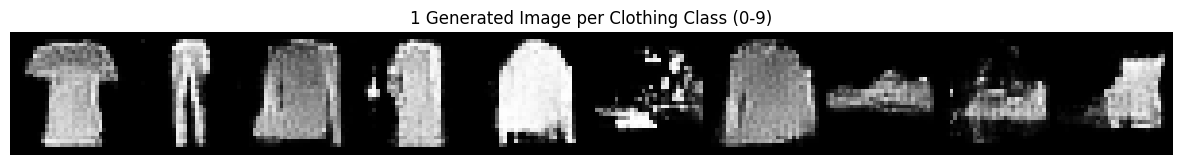

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Set model to evaluation mode
netG.eval()

# Generate one image for each clothing class (0-9)
z = torch.randn(10, nz).to(device)
labels = torch.arange(10).to(device)

with torch.no_grad():
    generated_images = netG(z, labels)

# Denormalize and visualize
grid = vutils.make_grid(generated_images.cpu(), nrow=10, normalize=True)
plt.figure(figsize=(15, 2))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("1 Generated Image per Clothing Class (0-9)")
plt.show()

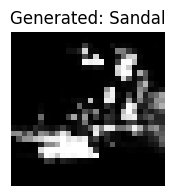

In [12]:
import torch.nn.functional as F

# Mapping from item name to class label
label_map = {
    "t-shirt": 0, "trouser": 1, "pullover": 2, "dress": 3, "coat": 4,
    "sandal": 5, "shirt": 6, "sneaker": 7, "bag": 8, "ankle boot": 9
}

def generate_item(item_name):
    label_idx = label_map.get(item_name.lower())
    if label_idx is None:
        print(f"Unknown item: {item_name}")
        return
    z = torch.randn(1, nz).to(device)
    label = torch.tensor([label_idx]).to(device)
    with torch.no_grad():
        generated = netG(z, label)
    img = generated.squeeze().cpu()
    plt.figure(figsize=(2,2))
    plt.imshow((img + 1) / 2, cmap='gray')  # denormalize
    plt.title(f"Generated: {item_name.title()}")
    plt.axis("off")
    plt.show()

# Example usage
generate_item("sandal")

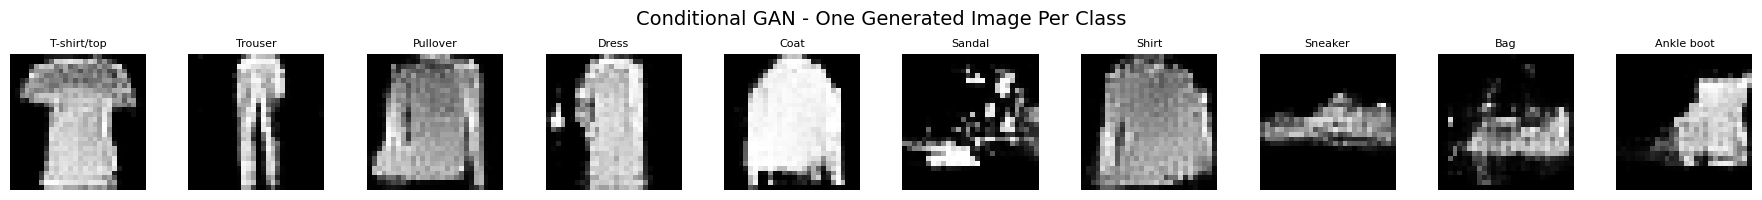

In [13]:
# Set model to evaluation mode
netG.eval()

# Generate one image for each clothing class (0-9)
z = torch.randn(10, nz).to(device)
labels = torch.arange(10).to(device)

with torch.no_grad():
    generated_images = netG(z, labels)

# Class names from Fashion-MNIST
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot each image with its label
fig, axes = plt.subplots(1, 10, figsize=(18, 2))
for i in range(10):
    img = generated_images[i].cpu().squeeze()
    axes[i].imshow((img + 1) / 2, cmap='gray')  # denormalize to [0,1]
    axes[i].set_title(class_names[i], fontsize=8)
    axes[i].axis("off")

plt.suptitle("Conditional GAN - One Generated Image Per Class", fontsize=14)
plt.tight_layout()
plt.show()